In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


In [2]:
X_train_orig = pd.read_csv('train.csv')
X_test_orig = pd.read_csv('test.csv')

In [3]:
X_train_orig.describe()
#X_train_orig.info()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
X_train_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
X_train_orig.head(3)
print(type(X_train_orig.Cabin))

<class 'pandas.core.series.Series'>


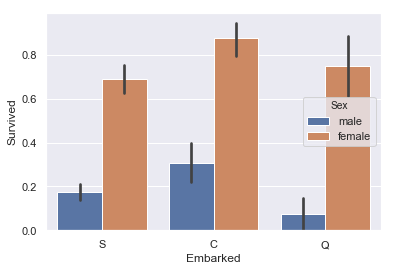

In [6]:
sns.set(style='darkgrid')
sns.barplot(x='Embarked',y='Survived',hue='Sex',data = X_train_orig);

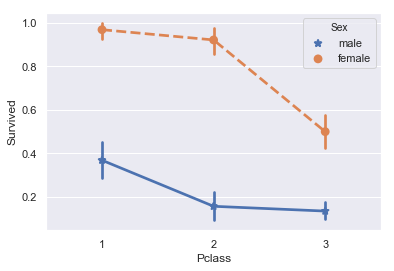

In [7]:
sns.pointplot(x='Pclass',y='Survived',hue='Sex',data=X_train_orig,markers=['*','o'],linestyles=['-','--']);

In [8]:
def simplify_age(df):
    df.Age.fillna(-0.5)
    bins = (-1,0,5,12,18,25,35,60,120)
    group_names = ['unknown','baby','child','teenager','student','young_adult','adult','senior']
    categories = pd.cut(df.Age,bins,labels=group_names)
    df.Age=categories
    return df
def simplify_cabins(df):
    df['Cabin'] = df['Cabin'].astype(str)
    df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df
def simplify_fare(df):
    df.Fare.fillna(-0.5)
    bins = (-1,0,8,15,31,513)
    group_names = ['unknown','1_quartile','2_quartile','3_quartile','4_quartile']
    df.Fare = pd.cut(df.Fare,bins,labels=group_names)
    return df
def drop_cols(df):
    df = df.drop(['Name','Ticket','PassengerId'],axis=1)
    return df
def simplify_data(df):
    df = simplify_age(df)
    df = simplify_cabins(df)
    df = simplify_fare(df)
    df = drop_cols(df)
    return df
df_train = simplify_data(X_train_orig)
df_test = simplify_data(X_test_orig)

In [9]:
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,student,1,0,1_quartile,n,S
1,1,1,female,adult,1,0,4_quartile,C,C
2,1,3,female,young_adult,0,0,1_quartile,n,S
3,1,1,female,young_adult,1,0,4_quartile,C,S
4,0,3,male,young_adult,0,0,2_quartile,n,S


In [10]:
df_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,male,young_adult,0,0,1_quartile,n,Q
1,3,female,adult,1,0,1_quartile,n,S
2,2,male,senior,0,0,2_quartile,n,Q
3,3,male,young_adult,0,0,2_quartile,n,S
4,3,female,student,1,1,2_quartile,n,S


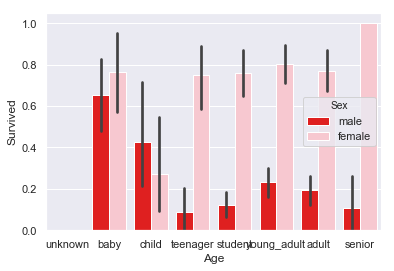

In [12]:
sns.barplot(x='Age',y='Survived',hue='Sex',data=df_train,
           palette = {'male':'red','female':'pink'});

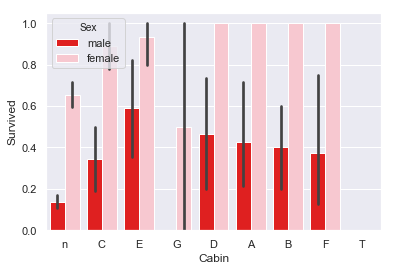

In [13]:
sns.barplot(x='Cabin',y='Survived',hue='Sex',data=df_train,
           palette = {'male':'red','female':'pink'});

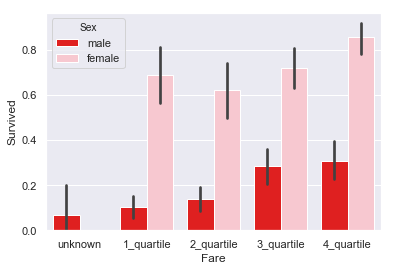

In [14]:
sns.barplot(x='Fare',y='Survived',hue='Sex',data=df_train,
           palette = {'male':'red','female':'pink'});

In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         714 non-null category
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null category
Cabin       891 non-null object
Embarked    889 non-null object
dtypes: category(2), int64(4), object(3)
memory usage: 51.1+ KB


In [16]:
from sklearn import preprocessing as p
def encode_features(df_train,df_test):
    features = ['Sex','Age','Cabin','Fare','Embarked']
    df_combined = pd.concat([df_train[features],df_test[features]])
    
    for feature in features:
        le = p.LabelEncoder()
        le = le.fit(df_combined[feature].astype(str))
        df_train[feature] = le.transform(df_train[feature].astype(str))
        df_test[feature] = le.transform(df_test[feature].astype(str))
    return df_train,df_test

df_train,df_test = encode_features(df_train,df_test)


In [17]:
from sklearn.model_selection import train_test_split
X = df_train.drop(['Survived'],axis=1)
y = df_train['Survived']

test_size = 0.20
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = test_size,random_state = 23)


In [18]:
classifier = RandomForestClassifier()
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)

C:\Users\sunny\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [19]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_pred,y_test)
print(accuracy)

0.8212290502793296


### Apply Kfold Validation

In [20]:
from sklearn.model_selection import KFold
kf= KFold(n_splits=10)
outcomes = []
fold = 0
for train_index,test_index in kf.split(X):
    fold+=1
    X_train,X_test = (X.values[train_index],X.values[test_index])
    y_train,y_test = (y.values[train_index],y.values[test_index])
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_pred,y_test)
    outcomes.append(accuracy)
    print('fold : {0} accuracy : {1}'.format(fold,accuracy))
accuracy = np.mean(outcomes)
print('overall accuracy : {0}'.format(accuracy))


fold : 1 accuracy : 0.7888888888888889
fold : 2 accuracy : 0.7752808988764045
fold : 3 accuracy : 0.7640449438202247
fold : 4 accuracy : 0.8314606741573034
fold : 5 accuracy : 0.8539325842696629
fold : 6 accuracy : 0.8089887640449438
fold : 7 accuracy : 0.8426966292134831
fold : 8 accuracy : 0.7303370786516854
fold : 9 accuracy : 0.8314606741573034
fold : 10 accuracy : 0.8314606741573034
overall accuracy : 0.8058551810237203


In [21]:
y_pred = classifier.predict(df_test)

In [30]:
for i in range(len(y_pred)):
    print(y_pred[i])

0
0
0
0
0
0
0
0
1
0
0
0
1
0
1
1
0
0
1
1
0
0
1
0
1
0
1
0
0
0
0
0
1
0
0
0
0
0
0
1
0
1
0
1
1
0
0
0
1
0
0
0
1
1
0
0
0
0
0
1
0
0
0
1
0
1
1
0
0
0
1
0
0
1
1
1
0
1
0
1
1
0
0
0
0
0
0
1
1
1
0
0
1
0
0
0
1
0
1
0
1
0
0
0
0
0
0
0
0
0
0
1
1
1
1
0
0
1
0
1
1
0
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
1
0
0
0
1
1
1
1
1
1
1
0
0
1
0
0
1
0
0
0
0
0
0
1
1
1
1
1
0
0
1
0
1
0
1
0
0
0
0
0
1
0
1
0
0
0
0
0
1
0
1
1
0
0
0
0
1
0
0
0
0
1
0
0
1
0
1
0
1
0
1
0
1
1
0
1
0
0
0
1
1
0
1
0
1
0
1
1
1
1
0
0
0
1
1
0
1
0
1
0
0
0
0
0
0
0
1
0
0
0
1
1
0
0
0
0
0
0
0
0
1
1
0
1
0
0
0
0
0
1
1
1
1
0
0
0
0
0
0
0
0
1
0
0
1
0
0
0
0
1
0
0
1
1
0
1
1
0
0
0
0
1
1
1
1
0
0
0
0
0
1
1
1
0
1
0
0
0
1
0
0
1
0
1
0
0
0
0
0
0
0
1
1
0
0
1
0
1
1
0
0
0
1
1
1
0
0
0
0
1
1
0
1
0
0
0
1
0
0
1
0
0
1
1
0
0
0
1
0
0
0
1
1
1
0
0
0
0
0
1
0
0
0
1
0
1
0
0
1
0
1
0
1
0
0
1
1
1
1
1
0
0
1
0
0
1
